**Outline:**
1. Loading Data:
- Use the provided starter code to load the dataset.
- Extract and store audio properties such as sampling rate, duration, and labels.

2. Basic Statistics:
- Compute basic statistics (mean, median, standard deviation) for audio properties.
- Visualize the distribution of these properties.

3. Audio Waveform Visualization:
- Plot waveforms for a few samples of real and fake audio.
- Compare waveforms visually.


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display as ld
from tqdm import tqdm

from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data

In [2]:
# Loading Data
def get_audio_ids(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None):
    all_audio_ids = get_codecfake_audio_id_list()
    
    if ids is not None:
        return ids
    elif indices is not None:
        return [all_audio_ids[i] for i in indices]
    elif first_n is not None:
        return all_audio_ids[:first_n]
    elif last_n is not None:
        return all_audio_ids[-last_n:]
    elif random_n is not None:
        if seed is not None:
            random.seed(seed)
        return random.sample(all_audio_ids, random_n)
    else:
        return all_audio_ids

def get_iterable_dataset(ids=None, indices=None, first_n=None, last_n=None, random_n=None, seed=None, cache_dir=None):
    audio_ids = get_audio_ids(ids=ids, indices=indices, first_n=first_n, last_n=last_n, random_n=random_n, seed=seed)
    iterable_dataset = load_audio_data(
        audio_ids=audio_ids,
        dataset='codecfake',
        cache_dir=cache_dir
    )
    return iterable_dataset

In [3]:
def extract_audio_properties(iterable_ds):
    data = []
    for sample in tqdm(iterable_ds):
        audio_array = sample['audio']['array']
        sampling_rate = sample['audio']['sampling_rate']
        real_or_fake = sample['real_or_fake']
        audio_id = sample['audio_id']
        duration = len(audio_array) / sampling_rate
        data.append({
            'audio_id': audio_id,
            'sampling_rate': sampling_rate,
            'duration': duration,
            'real_or_fake': real_or_fake
        })
    return pd.DataFrame(data)

# Loading a sample of the dataset
iterable_ds = get_iterable_dataset(first_n=1000, cache_dir='./cache')
audio_df = extract_audio_properties(iterable_ds)

audio_df

7000it [01:34, 73.73it/s]


,audio_id,sampling_rate,duration,real_or_fake
0,p225_002,48000,4.058667,R
1,p225_002,16000,4.080000,F03
2,p225_002,24000,4.066667,F04
3,p225_002,16000,3.394125,F01
4,p225_002,48000,4.062500,F05
...,...,...,...,...
6995,p228_272,16000,6.560000,F03
6996,p228_272,16000,6.540000,F02
6997,p228_272,16000,6.560000,F06
6998,p228_272,16000,5.854125,F01


In [5]:
def compute_statistics(df, column):
    return {
        'mean': np.mean(df[column]),
        'median': np.median(df[column]),
        'std_dev': np.std(df[column])
    }

duration_stats = compute_statistics(audio_df, 'duration')
sampling_rate_stats = compute_statistics(audio_df, 'sampling_rate')

print("Duration Statistics: ", duration_stats)
print("Sampling Rate Statistics: ", sampling_rate_stats)

Duration Statistics:  {'mean': 4.016843401785715, 'median': 3.64, 'std_dev': 1.5921729823766082}
Sampling Rate Statistics:  {'mean': 26285.714285714286, 'median': 16000.0, 'std_dev': 13997.084244475303}


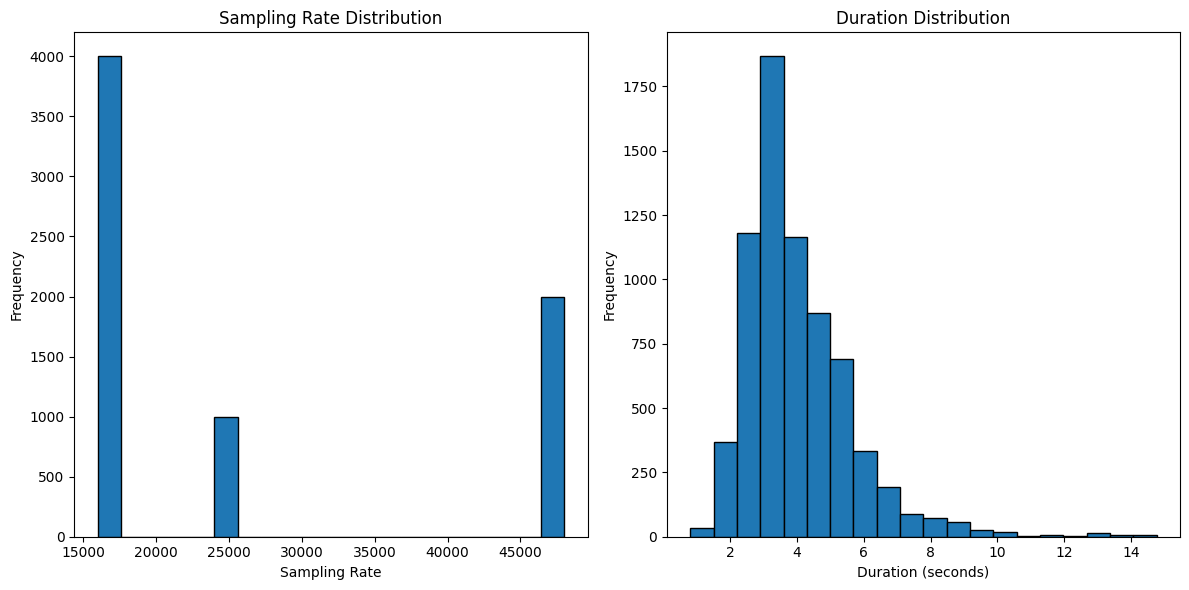

In [6]:

# Visualizing distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(audio_df['sampling_rate'], bins=20, edgecolor='k')
plt.title('Sampling Rate Distribution')
plt.xlabel('Sampling Rate')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(audio_df['duration'], bins=20, edgecolor='k')
plt.title('Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Audio Waveform Visualization
def plot_waveform(audio_array, sr, title='Waveform'):
    plt.figure(figsize=(10, 4))
    ld.waveshow(audio_array, sr=sr)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()


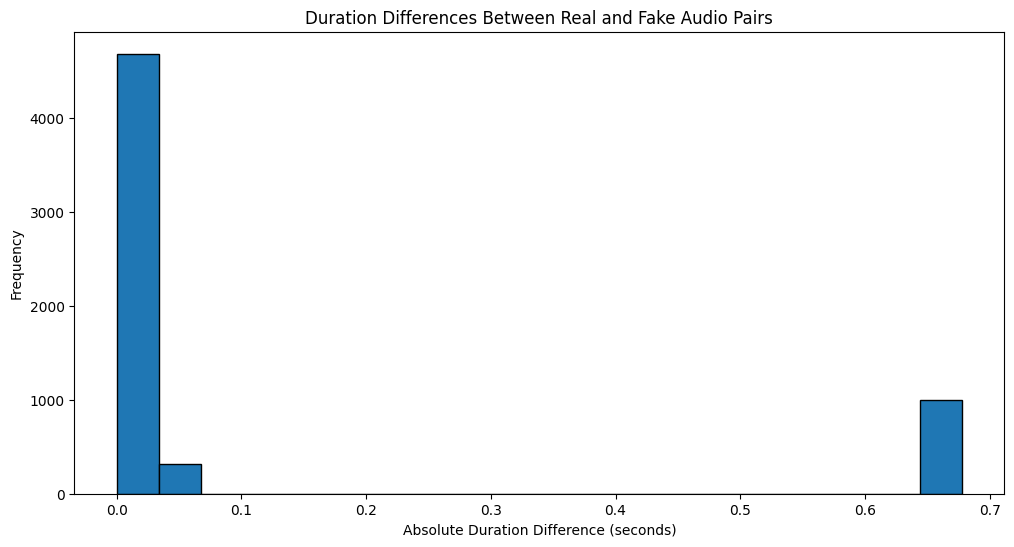

In [7]:
# Pairing Real and Fake Audios
paired_durations = []
for audio_id in audio_df['audio_id'].unique():
    real_audio = audio_df[(audio_df['audio_id'] == audio_id) & (audio_df['real_or_fake'] == 'R')]
    fake_audios = audio_df[(audio_df['audio_id'] == audio_id) & (audio_df['real_or_fake'] != 'R')]
    
    if not real_audio.empty and not fake_audios.empty:
        real_duration = real_audio['duration'].values[0]
        for _, fake_audio in fake_audios.iterrows():
            fake_duration = fake_audio['duration']
            duration_diff = abs(real_duration - fake_duration)
            paired_durations.append(duration_diff)

# Visualizing Duration Differences
plt.figure(figsize=(12, 6))
plt.hist(paired_durations, bins=20, edgecolor='k')
plt.title('Duration Differences Between Real and Fake Audio Pairs')
plt.xlabel('Absolute Duration Difference (seconds)')
plt.ylabel('Frequency')
plt.show()


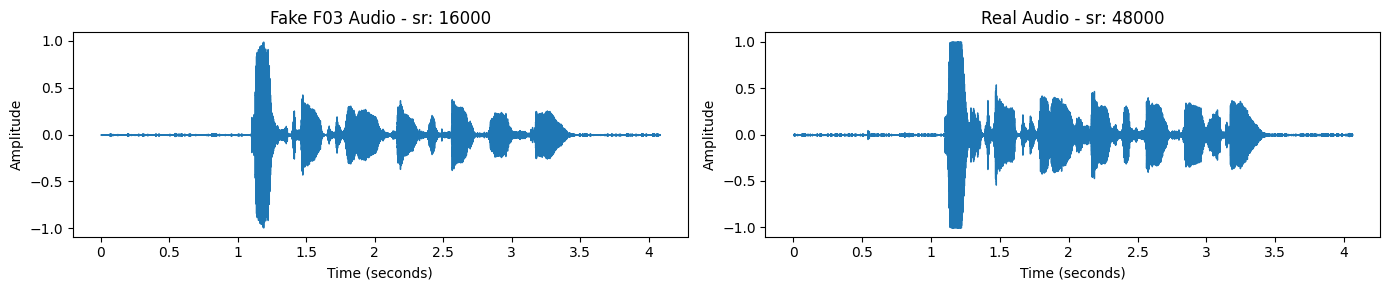

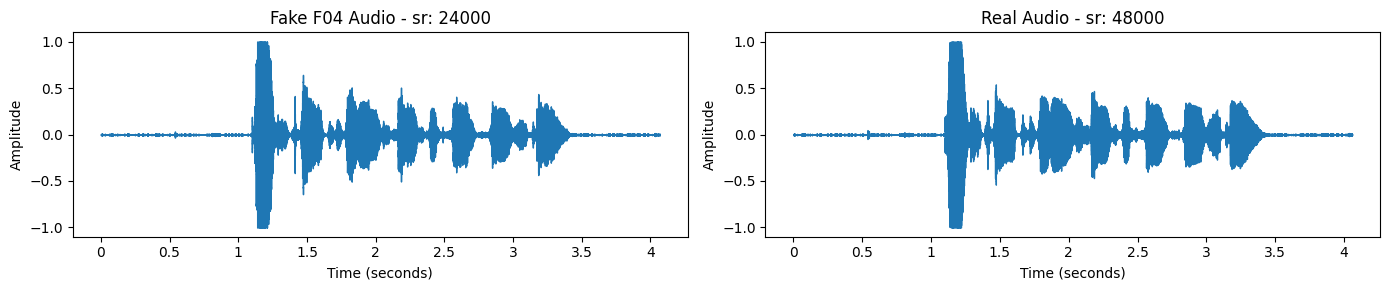

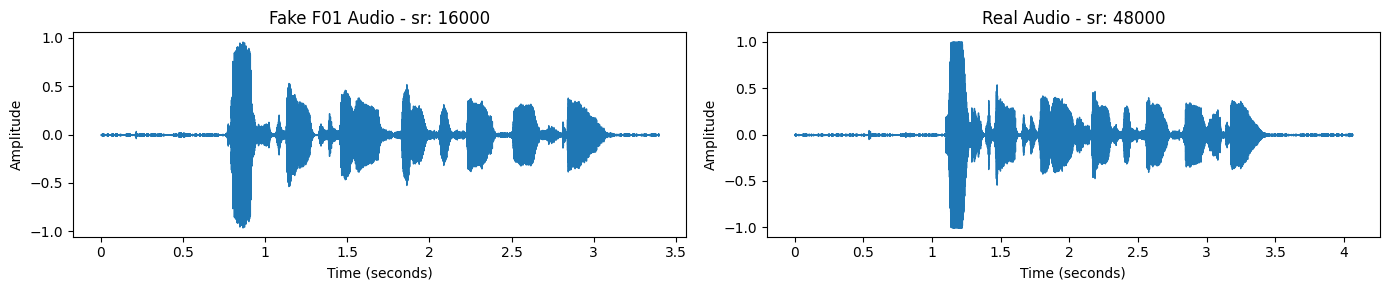

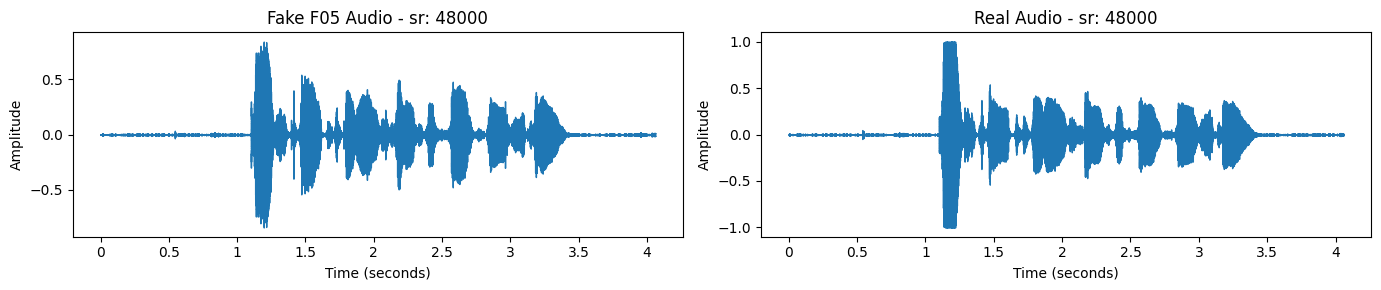

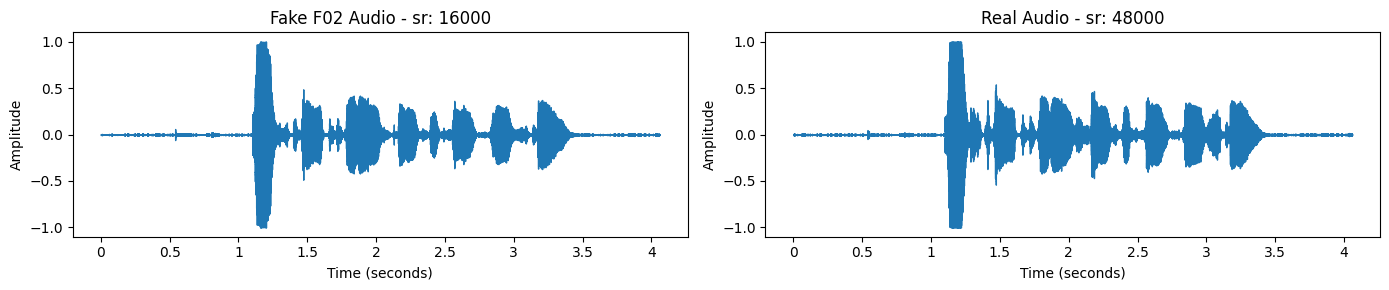

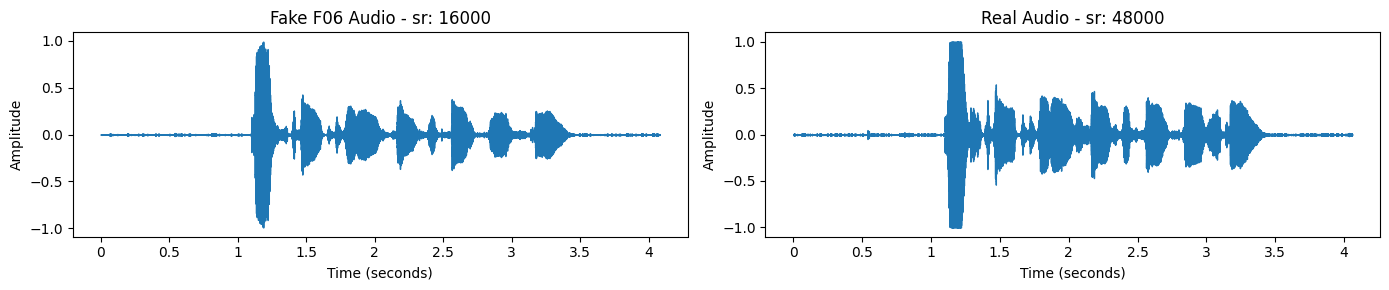

In [8]:
##  Plot Time Domain (Waveforms)
def plot_audio_pair(f_audio, r_audio, f_sr, r_sr, fake_version):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))
    
    # Plot fake audio waveform
    ld.waveshow(y=f_audio, sr=f_sr, ax=ax1)
    ax1.set_title(f'Fake {fake_version} Audio - sr: {f_sr}')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude')
    
    # Plot real audio waveform
    ld.waveshow(y=r_audio, sr=r_sr, ax=ax2)
    ax2.set_title(f'Real Audio - sr: {r_sr}')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

iterable_ds = get_iterable_dataset(first_n=1)

# Collect rows in a list of dictionaries
rows = []

# Process each sample in the dataset
for sample in iterable_ds:
    audio_array = sample['audio']['array']
    sampling_rate = sample['audio']['sampling_rate']
    real_or_fake = sample['real_or_fake']
    audio_id = sample['audio_id']
    
    # Append to the list of rows
    rows.append({
        'audio_id': audio_id,
        'audio_array': audio_array,
        'sampling_rate': sampling_rate,
        'real_or_fake': real_or_fake,
        'label':  0 if real_or_fake == 'R' else 1
    })

# Convert the list of dictionaries to a DataFrame
audio_df = pd.DataFrame(rows)

r_audio = audio_df.loc[0, 'audio_array']
r_sr    = audio_df.loc[0, 'sampling_rate']

for idx in range(1, 7):
    f_audio      = audio_df.loc[idx, 'audio_array']
    f_sr         = audio_df.loc[idx, 'sampling_rate']
    fake_version = audio_df.loc[idx, 'real_or_fake']
    plot_audio_pair(f_audio, r_audio, f_sr, r_sr, fake_version)
    